<font size="5">Fashion-MNIST Multilayer Perceptron (TensorFlow)</font>

<br />

<u>Upcoming<u/>
- Improve Performance
  - Write UDF using Keras Tuner for hyperparameter tuning (e.g., layers, neurons, learning rate, optimizer, neuron dropout rate) to optimize convergence and improve accuracy
- Evaluate Performance
  - Compare performance of later models to Model 1 on most error-prone classes
- Alternative Models
  - Neuron Dropout
    - Experiment with decreasing dropout rate across layers
    - Experiment with Monte Carlo Dropout for "Drop" model
  - Compare "Wide & Deep" model that learns simple rules and deep patterns 
  - Compare Convolutional Neural Network (CNN) to previous Sequential models

<br />

Development/progress notes below analysis

<br />

<u>Data/Task Notes<u/>
- Dataset contains 70,000 grayscale images of fashion items across 10 categories/classes, with information stored at the pixel level
  - Image dimensions are 28*28 pixels (784 total)
  - Data features consist of 784 pixel brightnesses (ranging from 0-255), with no colour (RGB/RGBA) information.
  - Data labels contain the true classification of each instance (integer encoding, 0-9).
- Since there is no emphasis on classifying any label in particular, and the full dataset conveniently includes equal proportions of all labels, train/validation/test sets are created with equal (stratified) proportions of instance labels.

In [1]:
#Imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from itertools import product
from pathlib import Path
from time import strftime
import datetime
import random
import warnings

%load_ext tensorboard

<h4 align="center"> Section 1: DataFrame Transformations </h4>

In [2]:
#Import full CSV data as DataFrame
fmnist_full = pd.read_csv(r'C:\Users\darkw\Desktop\f_mnist_full.csv')
print(fmnist_full.shape)
fmnist_full.head(2)

(70000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Verify dtypes
fmnist_full.dtypes[:5]

label     int64
pixel1    int64
pixel2    int64
pixel3    int64
pixel4    int64
dtype: object

In [4]:
#Establish indexed class list
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
#Sample 1a: Visualize record stored in full DataFrame
 #Select random df record
sample1a = fmnist_full.sample(1)
 #Output category from df
s1a_class = sample1a['label'].values[0]
print('Item clothing category:', class_names[s1a_class])
 #Preview index + attribute values
print(sample1a[['label','pixel18','pixel392','pixel750']])

Item clothing category: Dress
       label  pixel18  pixel392  pixel750
13187      3       79         0         0


In [6]:
 #Store sample features
sample1a = sample1a.drop(sample1a[['label']], axis=1)
s1a_vals = sample1a.values[0]
 #Reshape features for visualization
s1a_img = s1a_vals.reshape(28, 28)

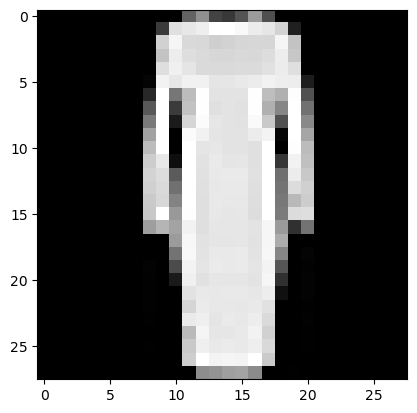

In [7]:
 #Display sample 1a in original cmap (grayscale)
plt.imshow(s1a_img, cmap='gray');

In [8]:
#Create target + feature dfs
y = fmnist_full['label']

X = fmnist_full.drop(fmnist_full[['label']], axis=1)
X.shape, y.shape

((70000, 784), (70000,))

In [9]:
#Review dataset balance
y.value_counts().sort_index()

label
0    7000
1    7000
2    7000
3    7000
4    7000
5    7000
6    7000
7    7000
8    7000
9    7000
Name: count, dtype: int64

In [10]:
#Transform target df to array
y = y.to_numpy()
y.shape

(70000,)

In [11]:
#Transform feature df to array + reshape for input layer
X_28 = X.to_numpy().reshape(70000, 28, 28)
X_28.shape

(70000, 28, 28)

<h4 align="center"> Section 2: Array Transformations </h4>

In [12]:
#Sample 1b: Re-locate sample 1a in array; visualize to verify
 #Store 1a index value; output to verify
s1_index = sample1a.index
s1_index

Index([13187], dtype='int64')

In [13]:
 #Output category from label array
s1b_class = y[s1_index][0]

print('Item clothing category:', class_names[s1b_class])

Item clothing category: Dress


In [14]:
 #Store feature values from reshaped array
sample1b = X_28[s1_index][0]
 #Display integer dtype/values
print(sample1b.dtype)
sample1b[0][0:40]

int64


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  99, 144,
        67,  56,  84, 155,  79,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int64)

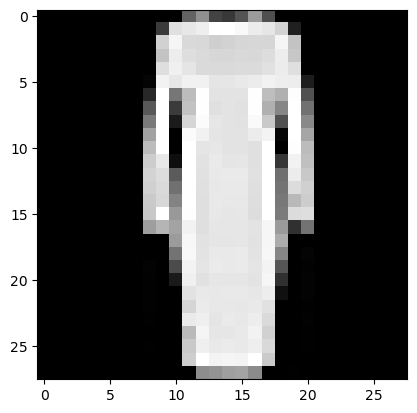

In [15]:
 #Display sample 1b in original cmap (grayscale)
plt.imshow(sample1b, cmap='gray');

In [16]:
#Split full dataset into 60,000 train + 10,000 test, maintaining label balance
X_train_full, X_te, y_train_full, y_te = train_test_split(X_28, y, test_size=1/7, stratify=y)

In [17]:
#Compare methods for creating validation set from training set
 #Keras training APIs include 'validation_split'; selects "the last samples in the x and y data provided, before shuffling"
  #Check last 5000 labels to evaluate would-be balance of validation set created by index slice/keras method
y_last5k = y_train_full[-5000:]

In [18]:
value1, count1 = np.unique(y_last5k, return_counts=True)

last5k_dict = dict(map(lambda label, freq : (label,freq) , value1, count1))

for i in last5k_dict:
    print(i, last5k_dict[i])

0 489
1 480
2 521
3 514
4 466
5 517
6 532
7 495
8 482
9 504


In [19]:
#Split training data into 55,000 train + 5,000 validation
 #Opting for sklearn 'train_test_split' to stratify by label, preserving label balance more precisely
X_train, X_valid, y_tr, y_val = train_test_split(X_train_full, y_train_full, test_size=1/12, stratify=y_train_full)

In [20]:
#Verify balance
 #Count label frequencies by set
value2, count2 = np.unique(y_tr, return_counts=True)
value3, count3 = np.unique(y_val, return_counts=True)
value4, count4 = np.unique(y_te, return_counts=True)

In [21]:
 #Map and display dictionaries
  #Training label frequencies
label_dict1 = dict(map(lambda label, freq : (label,freq) , value2, count2))

for i in label_dict1:
    print(i, label_dict1[i])

0 5500
1 5500
2 5500
3 5500
4 5500
5 5500
6 5500
7 5500
8 5500
9 5500


In [22]:
  #Validation label frequencies
label_dict2 = dict(map(lambda label, freq : (label,freq) , value3, count3))

for i in label_dict2:
    print(i, label_dict2[i])

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [23]:
  #Test label frequencies
label_dict3 = dict(map(lambda label, freq : (label,freq) , value4, count4))

for i in label_dict3:
    print(i, label_dict3[i])

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


In [24]:
#Preview feature (pre-scaling) and label values from arrays
 #Features
X_valid[:1][0][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [25]:
 #Label
y_val[:1]

array([8], dtype=int64)

In [26]:
#Scale feature arrays from 0-255 (int) to 0.0-1.0 (float)
X_tr_sc, X_val_sc, X_te_sc = X_train/255., X_valid/255., X_te/255.

In [27]:
#Check post-scaling dtypes
X_tr_sc.dtype, X_val_sc.dtype, X_te_sc.dtype

(dtype('float64'), dtype('float64'), dtype('float64'))

<h4 align="center"> Section 3: Tensor transformations </h4>

In [28]:
#Transform feature + label sets to tensors; reduce respective precisions
X_tr_sc = tf.convert_to_tensor(X_tr_sc, dtype=tf.float32)
X_val_sc = tf.convert_to_tensor(X_val_sc, dtype=tf.float32)
X_te_sc = tf.convert_to_tensor(X_te_sc, dtype=tf.float32)

y_tr = tf.convert_to_tensor(y_tr, dtype=tf.int8)
y_val = tf.convert_to_tensor(y_val, dtype=tf.int8)
y_te = tf.convert_to_tensor(y_te, dtype=tf.int8)

In [29]:
 #Verify shapes
print(X_tr_sc.shape, y_tr.shape)
print(X_val_sc.shape, y_val.shape)
print(X_te_sc.shape, y_te.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [30]:
#Sample 2: Visualize post-splits, post-scaling sample from tensor
sample2 = X_tr_sc[0]
 #Verify transformation of features to float dtype; preview values
print(sample2.dtype)
sample2[27]

<dtype: 'float32'>


<tf.Tensor: shape=(28,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.05490196,
       0.2       , 0.13725491, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.34117648, 0.4392157 , 0.17254902, 0.        ,
       0.        , 0.        , 0.        ], dtype=float32)>

In [31]:
 #Output sample label + category from tensor
print(y_tr[0])

s2_class = y_tr[0]
print(class_names[s2_class])

tf.Tensor(2, shape=(), dtype=int8)
Pullover


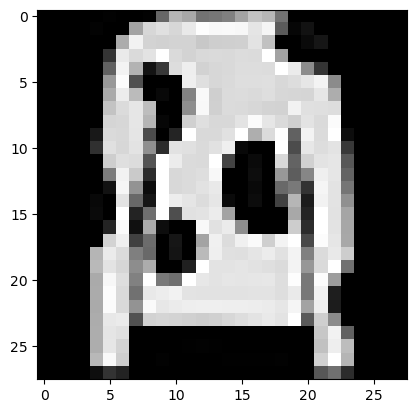

In [32]:
 #Display sample 2
plt.imshow(sample2, cmap='gray');

<h4 align="center"> Section 4: Model Building, Training & Storage </h4>

In [33]:
#TensorBoard log directory setup
log_dir1 = "Tf_output/fit/FMNIST/M1_Base_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir2 = "Tf_output/fit/FMNIST/M2_Wide_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir3 = "Tf_output/fit/FMNIST/M3_Uni_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir4 = "Tf_output/fit/FMNIST/M4_Deep_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir5 = "Tf_output/fit/FMNIST/M5_Drop_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#Define callbacks
 #Event log callbacks
event_cb1 = tf.keras.callbacks.TensorBoard(log_dir=log_dir1, histogram_freq=1)
event_cb2 = tf.keras.callbacks.TensorBoard(log_dir=log_dir2, histogram_freq=1)
event_cb3 = tf.keras.callbacks.TensorBoard(log_dir=log_dir3, histogram_freq=1)
event_cb4 = tf.keras.callbacks.TensorBoard(log_dir=log_dir4, histogram_freq=1)
event_cb5 = tf.keras.callbacks.TensorBoard(log_dir=log_dir5, histogram_freq=1)
 #Model checkpoint callback
checkp_cb1 = tf.keras.callbacks.ModelCheckpoint("Tf_output/checkpoints/FMNIST/M1_Base.keras", save_best_only=True)
checkp_cb2 = tf.keras.callbacks.ModelCheckpoint("Tf_output/checkpoints/FMNIST/M2_Wide.keras", save_best_only=True)
checkp_cb3 = tf.keras.callbacks.ModelCheckpoint("Tf_output/checkpoints/FMNIST/M3_Uni.keras", save_best_only=True)
checkp_cb4 = tf.keras.callbacks.ModelCheckpoint("Tf_output/checkpoints/FMNIST/M4_Deep.keras", save_best_only=True)
checkp_cb5 = tf.keras.callbacks.ModelCheckpoint("Tf_output/checkpoints/FMNIST/M5_Drop.keras", save_best_only=True)
 #Early stopping callback
stop_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=11)
stop_cb2 = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, start_from_epoch=8)


#Bundle
cb_list1 = [event_cb1, checkp_cb1, stop_cb]
cb_list2 = [event_cb2, checkp_cb2, stop_cb]
cb_list3 = [event_cb3, checkp_cb3, stop_cb2]
cb_list4 = [event_cb4, checkp_cb4, stop_cb2]
cb_list5 = [event_cb5, checkp_cb5, stop_cb2]

In [35]:
#Build Network 1: "Base"
 #2 hidden layers (300*100 neurons)
dnn1 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28], name="Base_Flat"),
tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', name="Base_D1"),
tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', name="Base_D2"),
tf.keras.layers.Dense(10, activation='softmax', name="Base_D_Out")
], name="Base")

dnn1.summary()

Model: "Base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Base_Flat (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Base_D1 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Base_D2 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Base_D_Out (Dense)              │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
#Build Network 2: "Wide"
 #2 hidden layers (334*12 neurons)
dnn2 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28], name="Wide_Flat"),
tf.keras.layers.Dense(334, activation='relu', kernel_initializer='he_normal', name="Wide_D1"),
tf.keras.layers.Dense(12, activation='relu', kernel_initializer='he_normal', name="Wide_D2"),
tf.keras.layers.Dense(10, activation='softmax', name="Wide_D_Out")
], name="Wide")

dnn2.summary()

Model: "Wide"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Wide_Flat (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Wide_D1 (Dense)                 │ (None, 334)            │       262,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Wide_D2 (Dense)                 │ (None, 12)             │         4,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Wide_D_Out (Dense)              │ (None, 10)             │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,340 (1.02 MB)

 Trainable params: 266,340 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
#Build Network 3: "Uniform"
 #3 hidden layers (217*216*216 neurons)
dnn3 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28], name="Uni_Flat"),
tf.keras.layers.Dense(217, activation='relu', kernel_initializer='he_normal', name="Uni_D1"),
tf.keras.layers.Dense(216, activation='relu', kernel_initializer='he_normal', name="Uni_D2"),
tf.keras.layers.Dense(216, activation='relu', kernel_initializer='he_normal', name="Uni_D3"),
tf.keras.layers.Dense(10, activation='softmax', name="Uni_D_Out")
], name="Uniform")

dnn3.summary()

Model: "Uniform"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Uni_Flat (Flatten)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Uni_D1 (Dense)                  │ (None, 217)            │       170,345 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Uni_D2 (Dense)                  │ (None, 216)            │        47,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Uni_D3 (Dense)                  │ (None, 216)            │        46,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Uni_D_Out (Dense)               │ (None, 10)             │         2,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,475 (1.02 MB)

 Trainable params: 266,475 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
#Build Network 4: "Deep"
 #4 hidden layers (194*194*192*192 neurons)
dnn4 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28], name="Deep_Flat"),
tf.keras.layers.Dense(194, activation='relu', kernel_initializer='he_normal', name="Deep_D1"),
tf.keras.layers.Dense(194, activation='relu', kernel_initializer='he_normal', name="Deep_D2"),
tf.keras.layers.Dense(192, activation='relu', kernel_initializer='he_normal', name="Deep_D3"),
tf.keras.layers.Dense(192, activation='relu', kernel_initializer='he_normal', name="Deep_D4"),
tf.keras.layers.Dense(10, activation='softmax', name="Deep_D_Out")
], name="Deep")

dnn4.summary()

Model: "Deep"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Deep_Flat (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Deep_D1 (Dense)                 │ (None, 194)            │       152,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Deep_D2 (Dense)                 │ (None, 194)            │        37,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Deep_D3 (Dense)                 │ (None, 192)            │        37,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Deep_D4 (Dense)                 │ (None, 192)            │        37,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Deep_D_Out (Dense)              │ (None, 10)             │         1,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,546 (1.02 MB)

 Trainable params: 266,546 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
#Build Network 5: "Drop"
 #4 hidden layers (225*225*225*225 neurons)
dnn5 = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=[28,28], name="Drop_Flat"),
tf.keras.layers.Dense(225, activation='relu', kernel_initializer='he_normal', name="Drop_D1"),
tf.keras.layers.Dense(225, activation='relu', kernel_initializer='he_normal', name="Drop_D2"),
tf.keras.layers.Dense(225, activation='relu', kernel_initializer='he_normal', name="Drop_D3"),
tf.keras.layers.Dense(225, activation='relu', kernel_initializer='he_normal', name="Drop_D4"),
tf.keras.layers.Dropout(rate=0.1, name="Drop_Drop5"),
tf.keras.layers.Dense(10, activation='softmax', name="Drop_D_Out")
], name="Drop")

dnn5.summary()

Model: "Drop"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Drop_Flat (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_D1 (Dense)                 │ (None, 225)            │       176,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_D2 (Dense)                 │ (None, 225)            │        50,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_D3 (Dense)                 │ (None, 225)            │        50,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_D4 (Dense)                 │ (None, 225)            │        50,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_Drop5 (Dropout)            │ (None, 225)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Drop_D_Out (Dense)              │ (None, 10)             │         2,260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,435 (1.26 MB)

 Trainable params: 331,435 (1.26 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
#Preview initialized trainable parameters (weights and biases) for third layer of Model 1
 #Access + store third layer (second dense; 100 neurons)
layer_100node = dnn1.layers[2]
layer_100node.name

'Base_D2'

In [41]:
 #Store trainable parameters (30,000 weights, 100 biases)
weights_100, biases_100 = layer_100node.get_weights()

 #For densely connected layer, shape of 2-dimensional array containing weights between every neuron of previous (input) and selected layer 
print(weights_100.shape)
 #Preview array of randomly initialized weights
weights_100

(300, 100)


array([[-0.02423051, -0.11273867,  0.06436852, ...,  0.01392045,
         0.11938748, -0.01339463],
       [ 0.05307511,  0.08172551, -0.0449302 , ..., -0.02589226,
         0.10505276, -0.06532323],
       [-0.09615997, -0.03576512, -0.14046016, ..., -0.06080877,
        -0.07552954,  0.0038169 ],
       ...,
       [-0.08237218, -0.034789  , -0.01966179, ...,  0.06220244,
         0.05780239, -0.03404923],
       [-0.07331093, -0.05426094, -0.04876513, ..., -0.0759285 ,
         0.04793181, -0.03703226],
       [ 0.01919871,  0.01112867, -0.1603712 , ..., -0.09356798,
         0.0546881 , -0.01801091]], dtype=float32)

In [42]:
print(biases_100.shape)
 #Output untrained biases for each neuron
biases_100

(100,)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [43]:
#Create Exponential Decay learning rate schedule
#Set epoch count for training & learning rate schedule
 #Define learning rate schedule
epochs_train = 35
batch_size = 32

#SGD schedules
epochs_s_s = 12
steps_s_s = epochs_s_s * math.ceil(len(X_tr_sc)/batch_size)
sched_s_short = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=steps_s_s, decay_rate=0.1)

epochs_s_l = 20
steps_s_l = epochs_s_l * math.ceil(len(X_tr_sc)/batch_size)
sched_s_long = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, decay_steps=steps_s_l, decay_rate=0.1)

#Nadam schedules
epochs_n_s = 8
steps_n_s = epochs_n_s * math.ceil(len(X_tr_sc)/batch_size)
sched_n_short = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=steps_n_s, decay_rate=0.1)

epochs_n_l = 12
steps_n_l = epochs_n_l * math.ceil(len(X_tr_sc)/batch_size)
sched_n_long = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=steps_n_l, decay_rate=0.1)

In [44]:
#Configure optimizers, loss functions & performance metrics
#tf.keras.optimizers.SGD(learning_rate=sched_s_long, momentum=0.9, nesterov=True)
#Condense to 1?
optimizer1 = tf.keras.optimizers.Nadam(learning_rate=sched_n_long)
optimizer2 = tf.keras.optimizers.Nadam(learning_rate=sched_n_long)
optimizer3 = tf.keras.optimizers.Nadam(learning_rate=sched_n_short)
optimizer4 = tf.keras.optimizers.Nadam(learning_rate=sched_n_short)
optimizer5 = tf.keras.optimizers.Nadam(learning_rate=sched_n_short)

dnn1.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer1,
                   metrics=['accuracy'])

dnn2.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer2,
                   metrics=['accuracy'])

dnn3.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer3,
                   metrics=['accuracy'])

dnn4.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer4,
                   metrics=['accuracy'])

dnn5.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer5,
                   metrics=['accuracy'])

In [45]:
#Train networks + store results using loop

train_array = [[dnn1, cb_list1], 
              [dnn2, cb_list2],
              [dnn3, cb_list3],
              [dnn4, cb_list4],
              [dnn5, cb_list5]]

  #Container for history objects
history_list = []

  #Training loop
for network in train_array:
    dnn = network[0]
    CBs = network[1]
    history = dnn.fit(X_tr_sc, y_tr, epochs=epochs_train, validation_data=(X_val_sc, y_val), callbacks=CBs, verbose=2)
    history_list.append(history)

  #Store history objects in variables
history1 = history_list[0]
history2 = history_list[1]
history3 = history_list[2]
history4 = history_list[3]
history5 = history_list[4]

Epoch 1/35
1719/1719 - 4s - 3ms/step - accuracy: 0.8333 - loss: 0.4717 - val_accuracy: 0.8624 - val_loss: 0.3782
Epoch 2/35
1719/1719 - 3s - 2ms/step - accuracy: 0.8716 - loss: 0.3514 - val_accuracy: 0.8616 - val_loss: 0.3750
Epoch 3/35
1719/1719 - 4s - 2ms/step - accuracy: 0.8839 - loss: 0.3138 - val_accuracy: 0.8848 - val_loss: 0.3161
Epoch 4/35
1719/1719 - 3s - 2ms/step - accuracy: 0.8951 - loss: 0.2848 - val_accuracy: 0.8846 - val_loss: 0.3178
Epoch 5/35
1719/1719 - 3s - 2ms/step - accuracy: 0.9030 - loss: 0.2613 - val_accuracy: 0.8914 - val_loss: 0.2830
Epoch 6/35
1719/1719 - 3s - 2ms/step - accuracy: 0.9097 - loss: 0.2426 - val_accuracy: 0.8974 - val_loss: 0.2803
Epoch 7/35
1719/1719 - 3s - 2ms/step - accuracy: 0.9157 - loss: 0.2254 - val_accuracy: 0.8992 - val_loss: 0.2768
Epoch 8/35
1719/1719 - 3s - 2ms/step - accuracy: 0.9211 - loss: 0.2112 - val_accuracy: 0.8978 - val_loss: 0.2797
Epoch 9/35
1719/1719 - 3s - 2ms/step - accuracy: 0.9254 - loss: 0.1982 - val_accuracy: 0.8978 - 

In [46]:
history_list

In [47]:
#Preview post-training parameters for previously accessed (third) Model 1 layer
weights_100_tr, biases_100_tr = layer_100node.get_weights()
 #Trained weights
weights_100_tr

array([[-0.06592935, -0.10354937,  0.1051392 , ..., -0.00122729,
         0.06102286, -0.10191908],
       [ 0.11155979,  0.10842106, -0.04252194, ..., -0.06761605,
         0.11190356, -0.06366576],
       [-0.23287365, -0.06475593, -0.33478102, ..., -0.08448964,
         0.04717768,  0.15542498],
       ...,
       [-0.01970712, -0.05505984, -0.07773485, ...,  0.04375173,
         0.08585639, -0.02439146],
       [-0.21425477, -0.17830592,  0.09529731, ..., -0.11787969,
        -0.06650181,  0.00659849],
       [ 0.04288822, -0.03452715, -0.21768151, ..., -0.1171346 ,
         0.07953263, -0.01023096]], dtype=float32)

In [48]:
 #Trained biases
biases_100_tr

array([ 0.02126018,  0.11125626, -0.04746142,  0.2070954 ,  0.08073994,
        0.17657426,  0.00249136,  0.02721464, -0.05618055,  0.11587384,
        0.04697909, -0.06374803,  0.00318098,  0.07999057,  0.06277227,
        0.15595749,  0.1540864 ,  0.24770433,  0.05883851,  0.11599509,
        0.03619026,  0.09019151,  0.05965814, -0.02431846, -0.07738261,
        0.13330133,  0.19586246,  0.03796646,  0.14126109, -0.08451776,
        0.2947014 ,  0.01387757,  0.13346888,  0.00089915,  0.18580523,
        0.00340956, -0.04921085,  0.08192891, -0.01555676,  0.06346037,
        0.10353258,  0.23941159,  0.24957855, -0.04583426,  0.04342116,
        0.10527491,  0.08603396, -0.01437174, -0.04570721,  0.12586993,
        0.04954506,  0.04059539,  0.07059099, -0.04142876,  0.2418847 ,
        0.11276857,  0.17793661,  0.08017003, -0.04551544,  0.18401542,
        0.1156209 ,  0.1067945 ,  0.18933491,  0.10406415,  0.05125634,
        0.01352291,  0.03498099,  0.01917122,  0.19470006,  0.13

In [49]:
#Save best models
dnn1.save("Tf_output/models/FMNIST/best_dnn1.keras", overwrite=True)

dnn2.save("Tf_output/models/FMNIST/best_dnn2.keras", overwrite=True)

dnn3.save("Tf_output/models/FMNIST/best_dnn3.keras", overwrite=True)

dnn4.save("Tf_output/models/FMNIST/best_dnn4.keras", overwrite=True)

dnn5.save("Tf_output/models/FMNIST/best_dnn5.keras", overwrite=True)

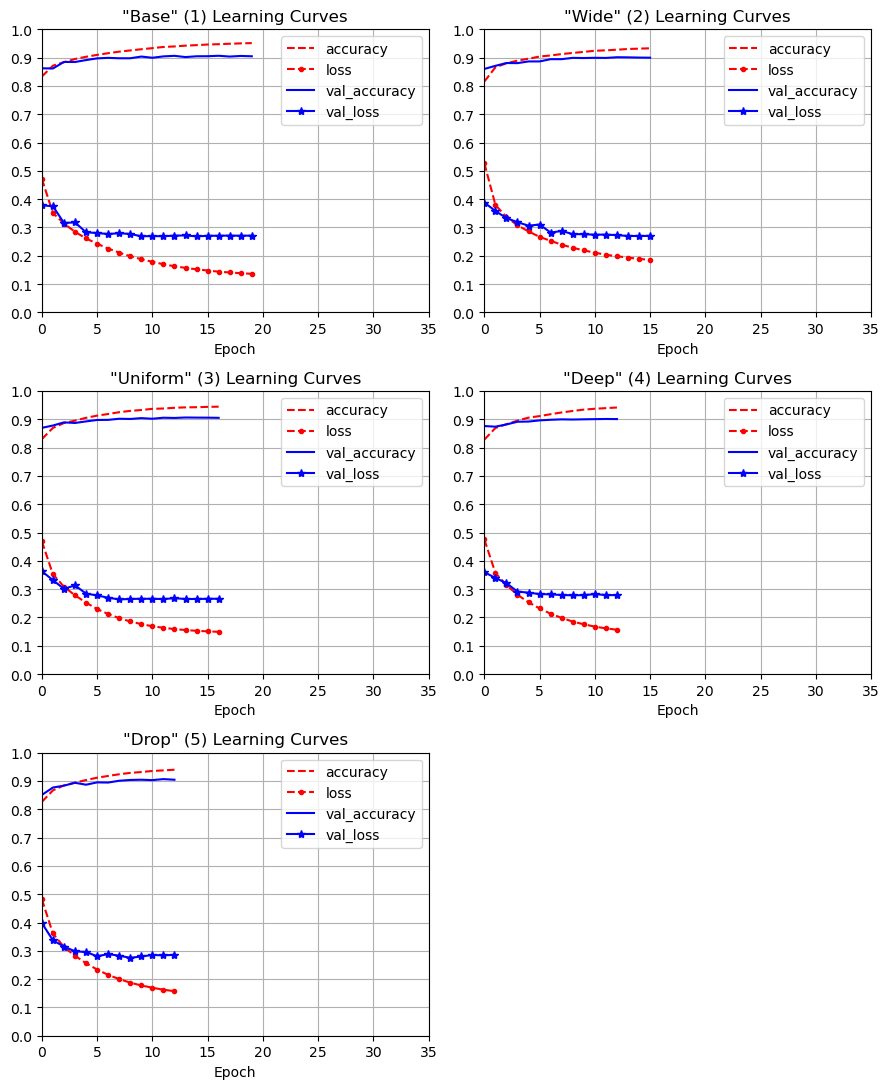

In [50]:
#Visualize learning curves manually
fig, axes = plt.subplots(3, 2, figsize=(9, 11))

 #Format + arrange
ytick_range = np.arange(0, 1.1, 0.1)

dnn1_learn_curves = pd.DataFrame(history1.history).plot(ax=axes[0,0],
    xlim=[0,epochs_train], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'], title='"Base" (1) Learning Curves', yticks=ytick_range)
dnn2_learn_curves = pd.DataFrame(history2.history).plot(ax=axes[0,1],
    xlim=[0,epochs_train], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'], title='"Wide" (2) Learning Curves', yticks=ytick_range)
dnn3_learn_curves = pd.DataFrame(history3.history).plot(ax=axes[1,0],
    xlim=[0,epochs_train], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'], title='"Uniform" (3) Learning Curves', yticks=ytick_range)
dnn4_learn_curves = pd.DataFrame(history4.history).plot(ax=axes[1,1],
    xlim=[0,epochs_train], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'], title='"Deep" (4) Learning Curves', yticks=ytick_range)
dnn5_learn_curves = pd.DataFrame(history5.history).plot(ax=axes[2,0],
    xlim=[0,epochs_train], ylim=[0,1], grid=True, xlabel="Epoch", style=['r--','r--.','b-','b-*'], title='"Drop" (5) Learning Curves', yticks=ytick_range)
 #Delete 6th plot
fig.delaxes(axes[2,1])

 #Display plots
plt.tight_layout()
plt.show()

In [51]:
#Display learning curves in TensorBoard
%tensorboard --logdir Tf_output/fit/FMNIST --host localhost

TensorBoard: validation accuracies/losses visualized by model and run, with comparison tooltip (screencap; does not function in GitHub)
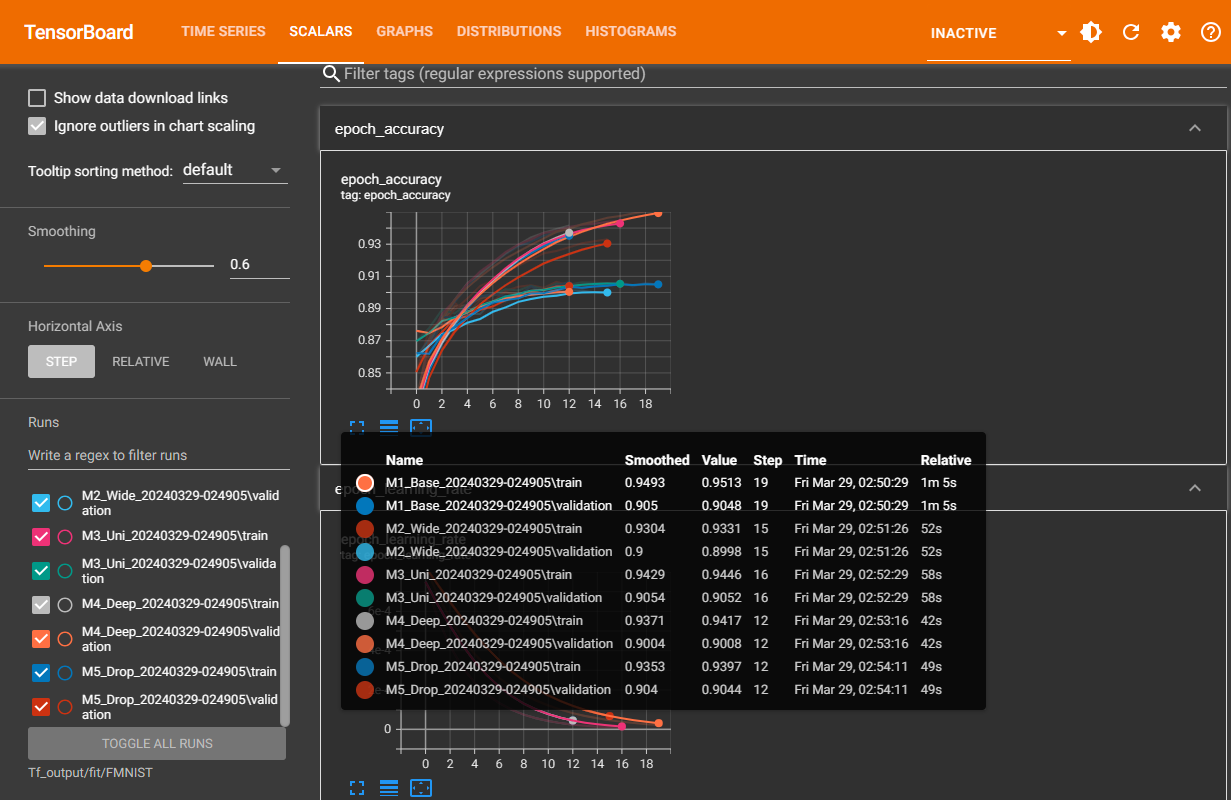

<h4 align="center"> Section 5: Predictive Performance Analysis </h4>

In [52]:
#Load best models for evaluation
best_dnn1 = tf.keras.models.load_model("Tf_output/models/FMNIST/best_dnn1.keras")
best_dnn2 = tf.keras.models.load_model("Tf_output/models/FMNIST/best_dnn2.keras")
best_dnn3 = tf.keras.models.load_model("Tf_output/models/FMNIST/best_dnn3.keras")
best_dnn4 = tf.keras.models.load_model("Tf_output/models/FMNIST/best_dnn4.keras")
best_dnn5 = tf.keras.models.load_model("Tf_output/models/FMNIST/best_dnn5.keras")

In [53]:
#Evaluate best 'Model 1' on unseen test set
best_dnn1.evaluate(X_te_sc, y_te)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.9095 - loss: 0.2629


[0.27144429087638855, 0.9083999991416931]

In [54]:
 #Verify result with original / non-loaded model
dnn1.evaluate(X_te_sc, y_te)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.9095 - loss: 0.2629


[0.27144429087638855, 0.9083999991416931]

In [55]:
#Evaluate all best models + compile results in df

best_list = [best_dnn1, best_dnn2, best_dnn3, best_dnn4, best_dnn5]

count_test_metrics = 0

test_df = pd.DataFrame(columns=['Test Loss', 'Test Accuracy'])

 #Loop
for model in best_list:
    loss, accuracy = model.evaluate(X_te_sc, y_te)
    test_df.loc[count_test_metrics] = [loss, accuracy]
    test_df.rename(index={count_test_metrics: best_list[count_test_metrics].name}, inplace=True)
    count_test_metrics+=1

 #Present in df
test_df

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.9095 - loss: 0.2629
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.9005 - loss: 0.2793
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.9077 - loss: 0.2630
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9037 - loss: 0.2683
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9047 - loss: 0.2729


,Test Loss,Test Accuracy
Base,0.271444,0.9084
Wide,0.281984,0.9003
Uniform,0.268205,0.9075
Deep,0.279532,0.9019
Drop,0.280902,0.9037


In [56]:
#Generate + store predictions from models
preds1 = best_dnn1.predict(X_te_sc)
preds2 = best_dnn2.predict(X_te_sc)
preds3 = best_dnn3.predict(X_te_sc)
preds4 = best_dnn4.predict(X_te_sc)
preds5 = best_dnn5.predict(X_te_sc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step


In [57]:
#Review shapes for test label+prediction arrays
 #Prediction array includes one probability per class, for each instance
print(y_te.shape, preds1.shape)
print('Example classwise probabilities:')
pd.DataFrame({'Probabilities': preds1[0]})

(10000,) (10000, 10)
Example classwise probabilities:


,Probabilities
0,5.032572e-05
1,1.228945e-06
2,5.255782e-04
3,9.835593e-01
4,1.397900e-02
5,3.721370e-08
6,1.881794e-03
7,1.120371e-08
8,2.678355e-06
9,5.603181e-08


Instance #: 4898/10,000
True class of instance: tf.Tensor(6, shape=(), dtype=int8) (Shirt)
Predicted class of instance: 6 (Shirt)
Model's confidence in prediction: 0.9996475
AxesImage(shape=(28, 28))


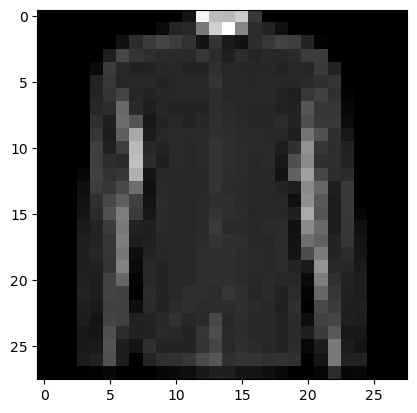

In [58]:
#Sample 3: Compare actual and predicted class for random prediction set instance
 #Select index value for sample
instance_val = random.randint(0,10000)

 #Store values
sample4 = X_te_sc[instance_val]
s4_class_true = y_te[instance_val]
s4_class_pred = np.argmax(preds1[instance_val])
s4_conf = max(preds1[instance_val])

 #Output instance #, true class, predicted class, and prediction confidence for sample
print('Instance #: '+str(instance_val+1)+'/10,000')
print('True class of instance: '+str(s4_class_true)+' ('+class_names[s4_class_true]+')')
print('Predicted class of instance: '+str(s4_class_pred)+' ('+class_names[s4_class_pred]+')')
print('Model\'s confidence in prediction: '+str(s4_conf))

#Display sample 4 image
print(plt.imshow(sample4, cmap='gray'));

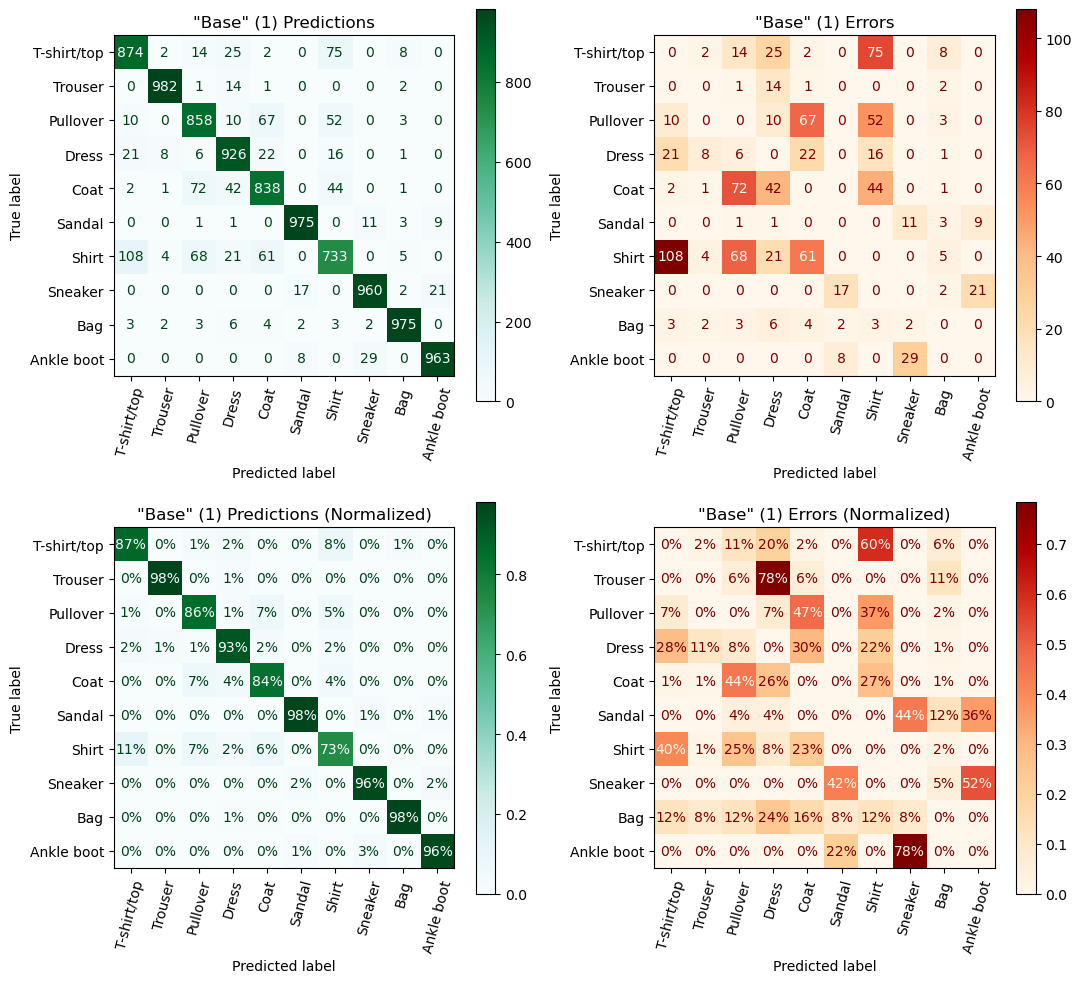

In [59]:
#Confusion Matrices: Model 1
sample_weights1 = (np.argmax(preds1, axis=1) != y_te)

fig, axes = plt.subplots(2, 2, figsize=(11, 10))

 #Format + arrange
  #Matrices 1c + 1d normalized by row
confusion_matrix1a = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), cmap='BuGn', ax=axes[0, 0], display_labels=class_names, xticks_rotation=75)
axes[0, 0].set_title('"Base" (1) Predictions')
confusion_matrix1b = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), cmap='OrRd', ax=axes[0, 1], sample_weight=sample_weights1, display_labels=class_names, xticks_rotation=75)
axes[0, 1].set_title('"Base" (1) Errors')
confusion_matrix1c = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), cmap='BuGn', ax=axes[1, 0], values_format='.0%', normalize='true', display_labels=class_names, xticks_rotation=75)
axes[1, 0].set_title('"Base" (1) Predictions (Normalized)')
confusion_matrix1d = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds1, axis=1), cmap='OrRd', ax=axes[1, 1], values_format='.0%', normalize='true', sample_weight=sample_weights1, display_labels=class_names, xticks_rotation=75)
axes[1, 1].set_title('"Base" (1) Errors (Normalized)')

 #Display matrices
plt.tight_layout()
plt.show()

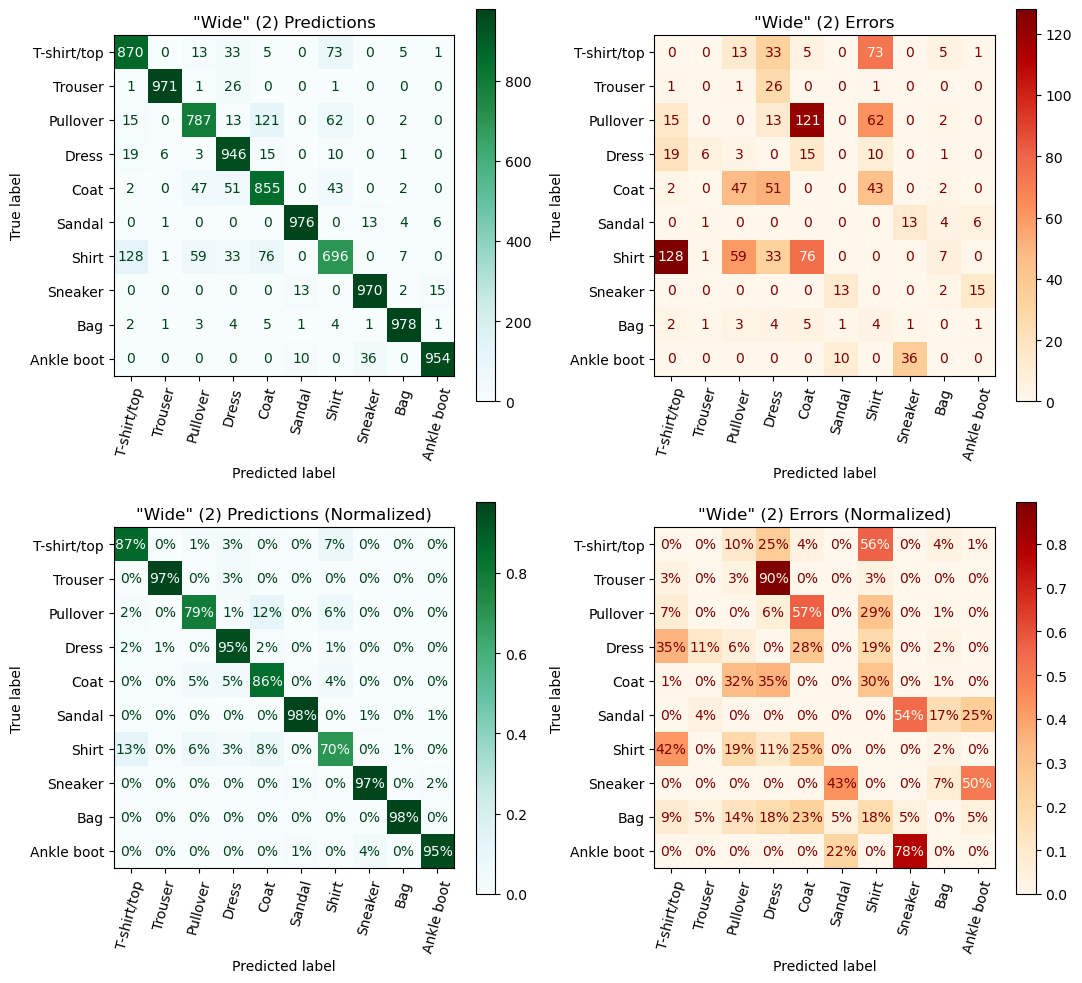

In [60]:
#Confusion Matrices: Model 2
sample_weights2 = (np.argmax(preds2, axis=1) != y_te)

fig, axes = plt.subplots(2, 2, figsize=(11, 10))

 #Format + arrange
  #Matrices 2c + 2d normalized by row
confusion_matrix2a = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds2, axis=1), cmap='BuGn', ax=axes[0, 0], display_labels=class_names, xticks_rotation=75)
axes[0, 0].set_title('"Wide" (2) Predictions')
confusion_matrix2b = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds2, axis=1), cmap='OrRd', ax=axes[0, 1], sample_weight=sample_weights2, display_labels=class_names, xticks_rotation=75)
axes[0, 1].set_title('"Wide" (2) Errors')
confusion_matrix2c = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds2, axis=1), cmap='BuGn', ax=axes[1, 0], values_format='.0%', normalize='true', display_labels=class_names, xticks_rotation=75)
axes[1, 0].set_title('"Wide" (2) Predictions (Normalized)')
confusion_matrix2d = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds2, axis=1), cmap='OrRd', ax=axes[1, 1], values_format='.0%', normalize='true', sample_weight=sample_weights2, display_labels=class_names, xticks_rotation=75)
axes[1, 1].set_title('"Wide" (2) Errors (Normalized)')

 #Display matrices
plt.tight_layout()
plt.show()

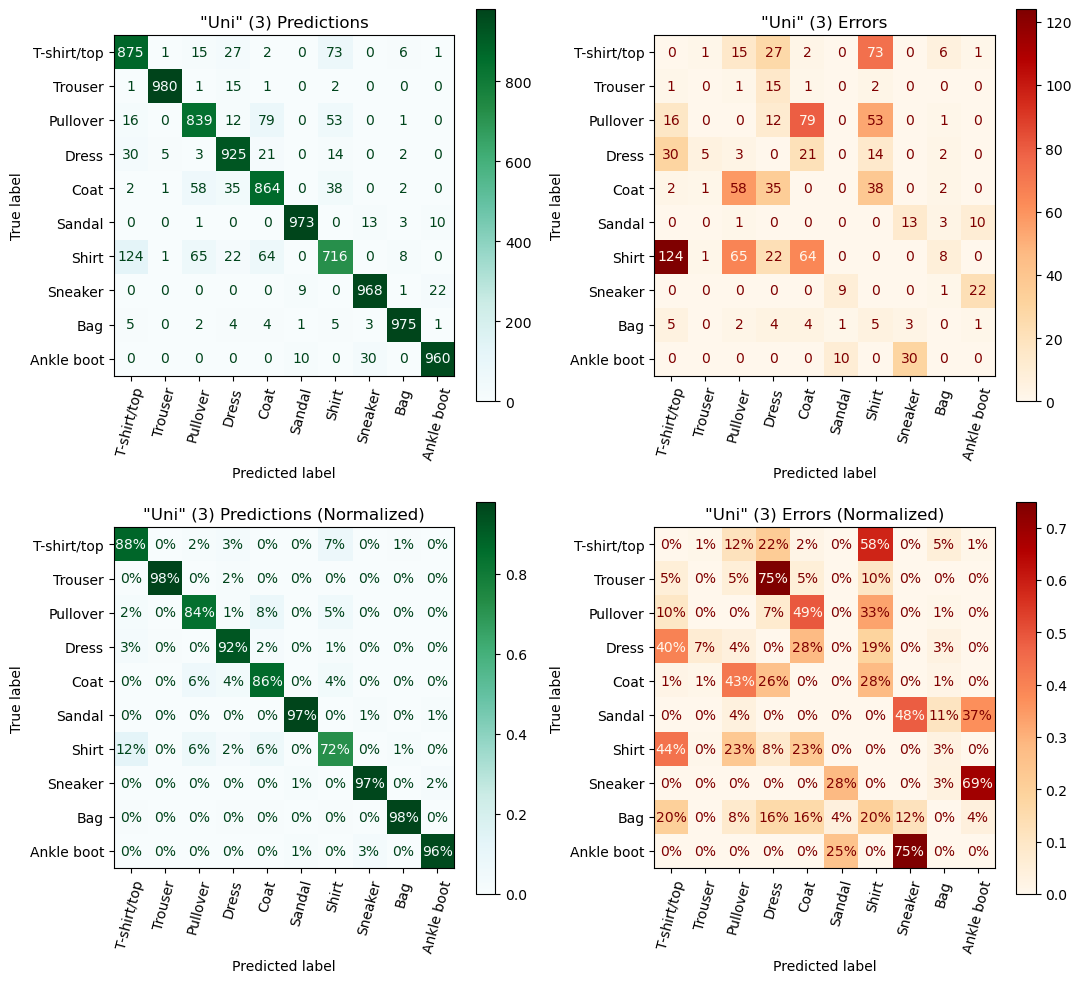

In [61]:
#Confusion Matrices: Model 3
sample_weights3 = (np.argmax(preds3, axis=1) != y_te)

fig, axes = plt.subplots(2, 2, figsize=(11, 10))

 #Format + arrange
  #Matrices 3c + 3d normalized by row
confusion_matrix3a = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds3, axis=1), cmap='BuGn', ax=axes[0, 0], display_labels=class_names, xticks_rotation=75)
axes[0, 0].set_title('"Uni" (3) Predictions')
confusion_matrix3b = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds3, axis=1), cmap='OrRd', ax=axes[0, 1], sample_weight=sample_weights3, display_labels=class_names, xticks_rotation=75)
axes[0, 1].set_title('"Uni" (3) Errors')
confusion_matrix3c = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds3, axis=1), cmap='BuGn', ax=axes[1, 0], values_format='.0%', normalize='true', display_labels=class_names, xticks_rotation=75)
axes[1, 0].set_title('"Uni" (3) Predictions (Normalized)')
confusion_matrix3d = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds3, axis=1), cmap='OrRd', ax=axes[1, 1], values_format='.0%', normalize='true', sample_weight=sample_weights3, display_labels=class_names, xticks_rotation=75)
axes[1, 1].set_title('"Uni" (3) Errors (Normalized)')

 #Display matrices
plt.tight_layout()
plt.show()

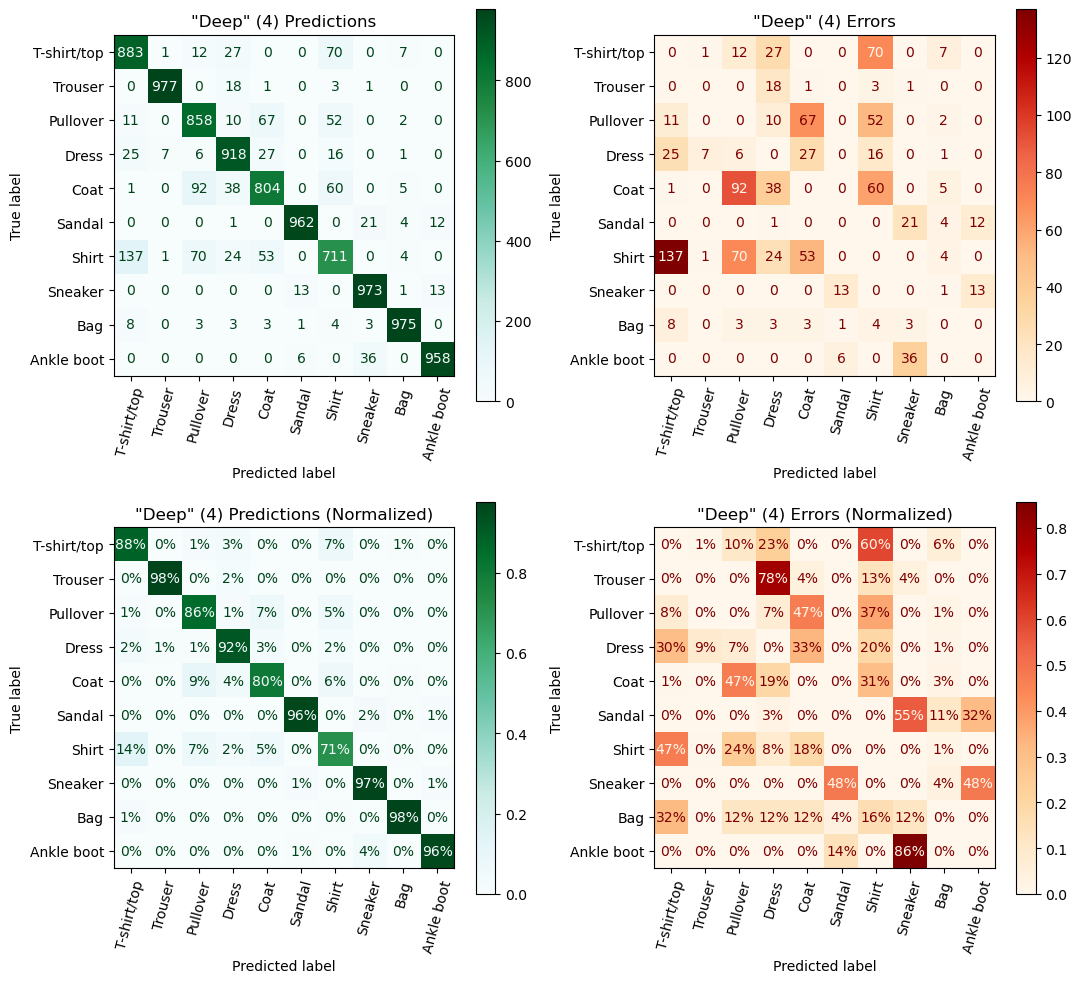

In [62]:
#Confusion Matrices: Model 4
sample_weights4 = (np.argmax(preds4, axis=1) != y_te)

fig, axes = plt.subplots(2, 2, figsize=(11, 10))

 #Format + arrange
  #Matrices 4c + 4d normalized by row
confusion_matrix4a = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds4, axis=1), cmap='BuGn', ax=axes[0, 0], display_labels=class_names, xticks_rotation=75)
axes[0, 0].set_title('"Deep" (4) Predictions')
confusion_matrix4b = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds4, axis=1), cmap='OrRd', ax=axes[0, 1], sample_weight=sample_weights4, display_labels=class_names, xticks_rotation=75)
axes[0, 1].set_title('"Deep" (4) Errors')
confusion_matrix4c = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds4, axis=1), cmap='BuGn', ax=axes[1, 0], values_format='.0%', normalize='true', display_labels=class_names, xticks_rotation=75)
axes[1, 0].set_title('"Deep" (4) Predictions (Normalized)')
confusion_matrix4d = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds4, axis=1), cmap='OrRd', ax=axes[1, 1], values_format='.0%', normalize='true', sample_weight=sample_weights4, display_labels=class_names, xticks_rotation=75)
axes[1, 1].set_title('"Deep" (4) Errors (Normalized)')

 #Display matrices
plt.tight_layout()
plt.show()

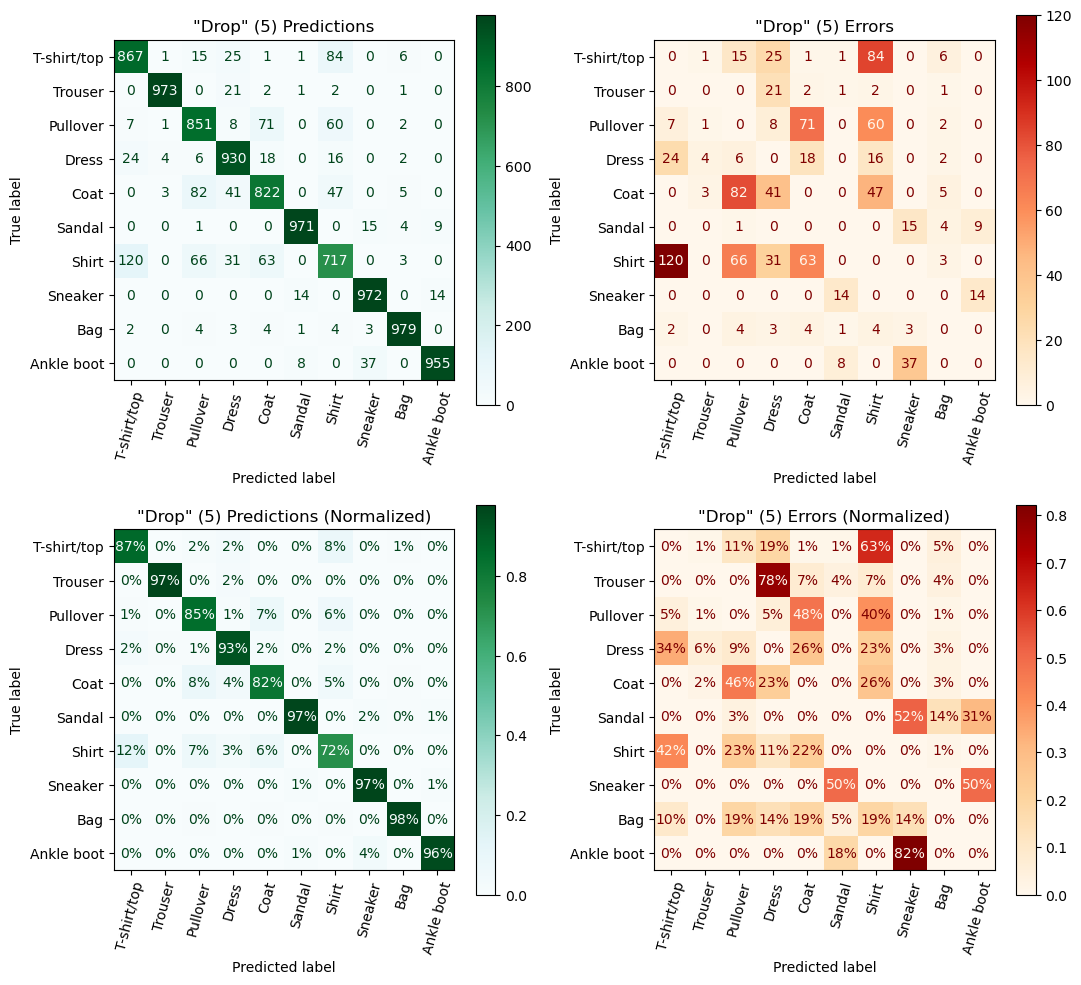

In [63]:
#Confusion Matrices: Model 5
sample_weights5 = (np.argmax(preds5, axis=1) != y_te)

fig, axes = plt.subplots(2, 2, figsize=(11, 10))

 #Format + arrange
  #Matrices 4c + 4d normalized by row
confusion_matrix5a = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds5, axis=1), cmap='BuGn', ax=axes[0, 0], display_labels=class_names, xticks_rotation=75)
axes[0, 0].set_title('"Drop" (5) Predictions')
confusion_matrix5b = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds5, axis=1), cmap='OrRd', ax=axes[0, 1], sample_weight=sample_weights5, display_labels=class_names, xticks_rotation=75)
axes[0, 1].set_title('"Drop" (5) Errors')
confusion_matrix5c = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds5, axis=1), cmap='BuGn', ax=axes[1, 0], values_format='.0%', normalize='true', display_labels=class_names, xticks_rotation=75)
axes[1, 0].set_title('"Drop" (5) Predictions (Normalized)')
confusion_matrix5d = ConfusionMatrixDisplay.from_predictions(y_te, np.argmax(preds5, axis=1), cmap='OrRd', ax=axes[1, 1], values_format='.0%', normalize='true', sample_weight=sample_weights5, display_labels=class_names, xticks_rotation=75)
axes[1, 1].set_title('"Drop" (5) Errors (Normalized)')

 #Display matrices
plt.tight_layout()
plt.show()

In [64]:
#Create dataframe of metrics corresponding to best weights, per model
history_list = [history1, history2, history3, history4, history5]

results_df = pd.DataFrame(columns=['# Convergence Epochs','Training Accuracy', 'Training Loss', 'Validation Accuracy', 'Validation Loss', 'Test Accuracy', 'Test Loss'])

count_hist_metrics = 0

for history in history_list:
    #Store training results in object
    train_results = history.history
    #Create dataframe of results object
    train_results_df = pd.DataFrame(history.history)
    #Find # of convergence epochs for best weights 
    best_epochs = np.argmin(train_results['val_loss'])
    #Find results corresponding to best weights/saved model
    best_row = train_results_df.iloc[best_epochs][['loss','accuracy','val_loss','val_accuracy']]
    #Insert results to df
    results_df.loc[count_hist_metrics] = [best_epochs, best_row['accuracy'], best_row['loss'], best_row['val_accuracy'], best_row['val_loss'], test_df.loc[best_list[count_hist_metrics].name]['Test Accuracy'], test_df.loc[best_list[count_hist_metrics].name]['Test Loss']]
    results_df.rename(index={count_hist_metrics: best_list[count_hist_metrics].name}, inplace=True)
    count_hist_metrics+=1

results_df

,# Convergence Epochs,Training Accuracy,Training Loss,Validation Accuracy,Validation Loss,Test Accuracy,Test Loss
Base,14.0,0.944200,0.152140,0.9048,0.268532,0.9084,0.271444
Wide,14.0,0.931782,0.188953,0.9002,0.269914,0.9003,0.281984
Uniform,7.0,0.925109,0.197497,0.9020,0.263484,0.9075,0.268205
Deep,8.0,0.929527,0.185348,0.8992,0.278196,0.9019,0.279532
Drop,8.0,0.928618,0.187436,0.9036,0.275253,0.9037,0.280902


# <h2 align="center"> Development Notes </h2>

<b><u>Model Notes<u/><b/>
- Models prior to "Drop" experiment with various structures while holding total trainable parameters (model size) constant, for comparison to "Base"
  - Performance for initial "Uniform" (2 layers, 200 neurons ea.) and "Deep" (3 layers, \~133 neurons ea.) models holding total # neurons constant was generally slightly worse (\~1% less accurate) 
    - While deeper networks have higher parameter efficiency, holding "total # neurons" constant meant narrowing the first dense layer to add depth
    - This reduced total trainable parameters more severely than narrowing other layers would (e.g., 784\*300 vs \*200 or \*134), as well as the network's capacity to learn fundamental low-level features.
- Created "Wide" model with more neurons in first hidden layer
- Created "Uniform" model with three layers of the same width
- Created "Deep" model with additional layer
- Created "Drop" model designed as a deep, uniform model narrower than "Base" to experiment with dropout regularization
    - Set weight initialization to He to improve ReLu activations
    - Removed dropout layers before final hidden layer for improved training and performance; this increased overfitting and test accuracy
    - Dropout in early layers reduced ability to learn low-level features

<b><u>Training Notes<u/><b/>
- Compared a variety of optimization techniques to improve convergence 
  - Added momentum term to models' stochastic gradient descent (SGD) algorithms, accelerating descent
    - This sped convergence by a factor of 4 in some cases (e.g., 40 to 11 epochs for "Base")
  - Changed optimizer to Nesterov Accelerated Gradient
  - Changed optimizer to Nadam (adaptive)
- Created second Early Stopping callback for separate configurations between models
  - Adjusted onset of validation loss monitoring in relation to convergence epochs and learning schedule, depending on model and optimizer
- Implemented separate Exponential Decay learning rate schedules for SGD and Nadam due to differing initial learning rates, reducing gradient step size throughout training
  - Implemented using Keras class + optimizer for step-wise updates (rather than epoch-wise with UDF + callback)
  - Improved tendency of validation loss to diverge in later epochs with nesterov acceleration
  - Lowered initial learning schedule epochs from 25 to ~8-12 due to faster convergence
- Lowered max training epochs from 50 to 35 due to faster convergences than simple SGD

<u><b>Data Engineering Process Notes<b/><u/>
- Output type checks, samples, and other information to validate data throughout transformations
- Imported full csv data to DataFrame
  - Sample 1a: randomly sampled data instance; reshaped, identified class/category, and displayed image
- Transformed df to 1- (labels) and 3-dimensional (features) ndarrays; reshaped feature array
  - Sample 1b: re-located 1a by index; identified, and displayed image
- Evaluated two methods for splitting data while preserving dataset balance; selected sklearn over keras method for precise stratification
  - Performed train/validation/test data splits
  - Scaled features to optimize for gradient descent
- Transformed numpy arrays to Tensorflow tensors
  - Provides GPU support (not supported in Windows), computational graphs for parallelization, gradient tape for advanced auto-differentiation
  - Reduced precision/bit depth of tensors to reduce memory use and computational cost
  - Sample 2: accessed new instance from tensor (instances re-indexed by splitting); identified, and displayed image
- Centralized output directory
  - Created separate event log directories; callbacks for event logs and model checkpoints
- Used single early stopping callback, after verifying that each trained model still returned separate "best weights" (i.e., early stopping callback object did not retain weights between models
- Accessed and compared pre-training & trained model attributes (e.g., layer weights & biases)
- Saved and loaded models in tensorflow format
- Sample 3: randomly sampled test set; compared model prediction to ground truth label, output prediction confidence, and displayed image

<b><u>Notebook Code Notes<u/><b/>
  - Scalability
    - Streamlined inclusion of additional models using condensed code, loops & lists (e.g., training/history creation, evaluation df, full results df)
  - Readability
    - Added DataFrames for results
    - Condensed matplotlib visuals using subplots
    - Simplified code and commented portions out
    - Renamed variables
    - Reformatted

<h2 align="center"> Evaluation of Performance by Model </h2>

<b>All models are compared to "Baseline"<b>

<b><u>Model 1: "Baseline"<u/><b/>
- 2 dense hidden layers; 300 & 100 neurons
- Task metrics (classwise)
  - Test accuracy achieved: ~0.89-0.90
    - Highest for Trousers, Sandals, Sneakers, Bags, and Ankle Boots (95%+)
    - Lowest for T-shirt/tops, Pullovers, Dresses, Coats, Shirts (~66-86%)
  - Has the most difficulty distinguishing between clothing shapes made for upper-body, listed above (understandable, due to similarities/ambiguity)
    - 'Shirts' are particularly difficult to correctly classify (~66%)

<b><u>Model 2: "Wide"<u/><b/>
- 2 dense hidden layers; 334 & 12 neurons
  - Wider first layer, narrower second layer
 
<b><u>Model 3.1: "Uniform"<u/><b/>
- 3 dense hidden layers; ~216 neurons ea.
  - Narrower, uniform shape
- Task metrics (classwise)

<b><u>Model 4.1: "Deep"<u/><b/>
- 4 dense hidden layers; ~193 neurons ea.
  - Narrowest, deeper, uniform shape

<b><u>Model 5: "Drop" (Neuron dropout)<u/><b/>
- 4 dense hidden layers, 1 neuron dropout layer; 225 neurons ea.
  - Narrower, deeper uniform shape
 
<b><u>Model 6: "Wide & Deep"<u/><b/>

<b><u>Model 7: "Convolutional Neural Network (CNN)"<u/><b/>